In [ ]:
pip install pytrends

In [1]:
import pandas as pd
import requests
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import numpy
import seaborn as sns
import matplotlib.dates as mdates

%matplotlib inline

<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
# 0. Preliminary investigation

In [2]:
import yfinance as yf

stk = yf.Ticker('SPY')
# Get data from 2020 till today
data = stk.history(start = '2000-01-01')
# Specify the features that we want
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [3]:
# Update column names
data.columns = ['open','high','low','close','volume']
import numpy as np

# weekly_positive_trend=1 if price increases in 5 days, otherwise 0
data['weekly_positive_trend'] = np.where(data.close.shift(-5) > data.close, 1, 0)

<ipython-input-4-60135e939409>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df = data['2020'].copy()


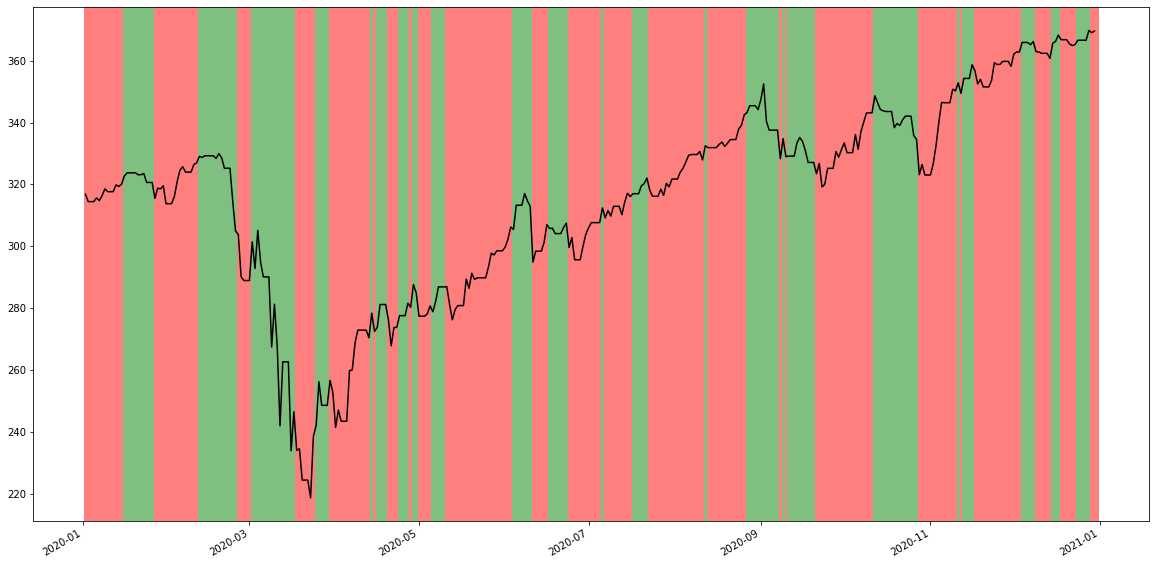

In [4]:
df = data['2020'].copy()
df = df.resample('D').ffill()

t = mdates.drange(df.index[0], df.index[-1], datetime.timedelta(hours = 24))
y = np.array(df.close[:-1])

fig, ax = plt.subplots()
ax.plot_date(t, y, 'b-', color = 'black')
for i in range(len(df)):
    if df.weekly_positive_trend[i] == 1:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor = 'red', edgecolor = 'none', alpha = 0.5   #Red for positive weekly trend
            )
    else:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor = 'green', edgecolor = 'none', alpha = 0.5  #Green for negative weekly trend
            )
fig.autofmt_xdate()
fig.set_size_inches(20, 10.5)
fig.savefig('SPY_weekly_positive_trend.png')

<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
# 1. Data Ingestion 

## 1.1 Ingest S&P 500 company stock prices and fundamental data

In [5]:
# Parse the list of S&P 500 stocks
url = 'https://www.slickcharts.com/sp500'
headers = {"User-Agent" : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'}

request = requests.get(url, headers = headers)

data = pd.read_html(request.text)[0]

# Create stk_lst based on the Symbol column
stk_list = data.Symbol

In [6]:
len(stk_list)

505

In [7]:
## Load data from Factset
basic_data_raw = pd.read_hdf('./data.h5')
basic_data_raw.head()

,Symbol,NAME,PRICE,MKT_VAL,ADV_1MTH,Sector,GICS_IND,GICS_SUBIND,S&P500 WGT,Date,...,Predicted PEG Ratio,Operating Margin,Low Accrual,Low Leverage,3 years EPS Variability,Interest Coverage Ratio,Medium Term momentum,Short Term reversal,Target price revision,Forward 5 trading days return_USD
2,,,,,,,,,,,,,,,,,,,,,
3,XOM,Exxon Mobil Corporation,73.12,368711.791115,1.330780e+09,Energy,Oil Gas & Consumable Fuels,Integrated Oil & Gas,3.225872,12/31/2010,...,2.038650,0.146332,0.092157,6.098122,1.044983,259.583784,4.560781,5.117893,6.322503,2.817285
4,AAPL,Apple Inc.,322.56,295886.554257,1.005045e+11,Information Technology,Technology Hardware Storage & Peripherals,Technology Hardware Storage & Peripherals,2.588721,12/31/2010,...,1.107213,0.284937,0.085527,0.000000,0.353221,NaN,47.651990,3.667045,9.772682,3.462923
5,MSFT,Microsoft Corporation,27.91,238784.657835,1.289837e+09,Information Technology,Software,Systems Software,1.839097,12/31/2010,...,1.024944,0.423480,0.152382,11.650645,0.173553,611.622222,-15.329720,10.501840,0.324547,3.260481
6,GE,General Electric Company,18.29,194874.833554,1.222912e+08,Industrials,Industrial Conglomerates,Industrial Conglomerates,1.704966,12/31/2010,...,1.224961,0.184282,2.247551,65.208929,0.312326,1.916678,6.741560,16.424510,4.201686,1.476204
7,CVX,Chevron Corporation,91.25,183634.053040,6.400711e+08,Energy,Oil Gas & Consumable Fuels,Integrated Oil & Gas,1.606620,12/31/2010,...,2.351561,0.150389,0.092376,5.992697,1.202346,93.749196,8.858299,12.696060,3.830981,-0.613695


The above table is a subset of the first 10 rows of the dataset. As we can see, the dataset is ordered in reverse chronological order with 72 columns and 10,000 rows. We are also able to observe that every column except for the `date`, `sunrise`, and `sunset` columns are numerical in nature. Moreover, we are able to see that the dataset has quite a few missing values.  

In [8]:
basic_data_raw.shape

(276368, 29)

In [9]:
## Keep only the data of current composition stocks (i.e. stocks in the stk_lst)
sp500_data_raw= basic_data_raw[basic_data_raw.Symbol.isin(stk_list)]

In [10]:
sp500_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222317 entries, 3 to 502
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Symbol                             222317 non-null  object 
 1   NAME                               222317 non-null  object 
 2   PRICE                              222317 non-null  float64
 3   MKT_VAL                            222317 non-null  float64
 4   ADV_1MTH                           222317 non-null  float64
 5   Sector                             222317 non-null  object 
 6   GICS_IND                           222317 non-null  object 
 7   GICS_SUBIND                        222317 non-null  object 
 8   S&P500 WGT                         222317 non-null  float64
 9   Date                               222317 non-null  object 
 10  SEDOL                              222317 non-null  object 
 11  Free CF Yield                      221232 

### 1.1.1 Missing Values 

In [11]:
def find_missing_vals(dataset):
    '''Display columsn with missing data and indicate how many values are missing for each column.'''
    missing_vals = dataset.isnull().sum()
    cols_list = dataset.columns
    col_count = 0

    for col, val in zip(cols_list, missing_vals):
        if val > 0:
            pct = round(val/len(dataset)*100, 4)
            print('{}: {} values misiing, consisting of {}%'.format(col, val, pct))
            col_count += 1
    print('\n{} columns have missing values'.format(col_count))
    return zip(cols_list, missing_vals)

In [12]:
find_missing_vals(sp500_data_raw)

Free CF Yield: 1085 values misiing, consisting of 0.488%
Target to Current price: 82 values misiing, consisting of 0.0369%
EBITDA / EV: 26167 values misiing, consisting of 11.7701%
Net Buyback Yield: 797 values misiing, consisting of 0.3585%
Trailing 3Y ROIC Growth: 3466 values misiing, consisting of 1.559%
Trailing 3Y Revenue Growth: 1889 values misiing, consisting of 0.8497%
Predicted Revenue Growth: 423 values misiing, consisting of 0.1903%
Predicted EPS LTG: 5076 values misiing, consisting of 2.2832%
Predicted PEG Ratio: 15560 values misiing, consisting of 6.999%
Operating Margin: 301 values misiing, consisting of 0.1354%
Low Accrual: 49258 values misiing, consisting of 22.1567%
Low Leverage: 83 values misiing, consisting of 0.0373%
3 years EPS Variability: 569 values misiing, consisting of 0.2559%
Interest Coverage Ratio: 14351 values misiing, consisting of 6.4552%
Medium Term momentum: 893 values misiing, consisting of 0.4017%
Short Term reversal: 41 values misiing, consisting of

In [13]:
##Getting rid of Low Accrual which has 20+% of values missing.
sp500_data_raw=sp500_data_raw.drop('Low Accrual', axis=1)

##Getting rid of GICS_IND and GICS_SUBIND which are too granular as categorical features; Use Sector alone
sp500_data_raw=sp500_data_raw.drop('GICS_IND', axis=1)
sp500_data_raw=sp500_data_raw.drop('GICS_SUBIND', axis=1)


## Coverting Date from object type to datetime
sp500_data_raw['Date'] = pd.to_datetime(sp500_data_raw['Date'].str.strip(), format='%m/%d/%Y').apply(lambda x: x.date())

In [14]:
# Drop null values
reduced_data_raw=sp500_data_raw.dropna()

In [15]:
find_missing_vals(reduced_data_raw)
reduced_data_raw.shape


0 columns have missing values


(166601, 26)

In [16]:
reduced_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166601 entries, 3 to 502
Data columns (total 26 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Symbol                             166601 non-null  object 
 1   NAME                               166601 non-null  object 
 2   PRICE                              166601 non-null  float64
 3   MKT_VAL                            166601 non-null  float64
 4   ADV_1MTH                           166601 non-null  float64
 5   Sector                             166601 non-null  object 
 6   S&P500 WGT                         166601 non-null  float64
 7   Date                               166601 non-null  object 
 8   SEDOL                              166601 non-null  object 
 9   Free CF Yield                      166601 non-null  float64
 10  Target to Current price            166601 non-null  float64
 11  EBITDA / EV                        166601 

In [17]:
reduced_data_raw["Date"].min()

datetime.date(2010, 12, 31)

## 1.2 Ingest Google trend data

In [ ]:
pip install pytrends

In [ ]:
import pytrends

In [ ]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import datetime as dt

# Specify timezone
#pytrend = TrendReq()
pytrends = TrendReq(hl = 'en-US', tz = 360)

# Specify the location as US
#pytrends.trending_searches(pn = 'united_states')

# Obtain daily trend info from Google trends
trend_data = pd.DataFrame(index = pd.date_range(start = '2010-12-31', end = dt.datetime.today(), freq = 'D'))

# Use the same stock list (stk_list) that parsed from previous steps
stk_list = stk_list.sort_values()

# there will be 270 daily records in each iteration
for rnd in range(int(np.ceil(len(trend_data) / 270))):
    # print the current round
    print('processing round :' + str(rnd))
    # update the start date and end date for each round
    date_list = list(trend_data.index[270*rnd:270*(rnd+1)])
    start_date = date_list[0].strftime('%Y-%m-%d')
    end_date = date_list[-1].strftime('%Y-%m-%d')
    
    # in this for loop, check trend info for each stock in the stk_list
    for stk in stk_list:
        kw_list = [stk]
        pytrends.build_payload(kw_list, timeframe = start_date + ' ' + end_date)
        try : 
            trend_data.loc[date_list, stk] = pytrends.interest_over_time()[stk]
        except : 
            trend_data.loc[date_list, stk] = np.nan
    time.sleep(5)
trend_data

In [ ]:
# It's worth to note that the numbers represent search interest relative to the highest point 
# on the chart for the given region and time (in this case 270 days). A value of 100 is the peak 
#popularity for the term. A value of 50 means that the term is half as popular. 
#A score of 0 means there was not enough data for this term.

##This step will normalize all popularity number to one scale for each stock.

start_date = trend_data.index[0].strftime('%Y-%m-%d')
end_date = trend_data.index[-1].strftime('%Y-%m-%d')

# 
for stk in stk_list:
    # Check the popularity for the whole period
    kw_list = [stk]
    pytrends.build_payload(kw_list, timeframe = start_date + ' ' + end_date)
    pytrends.interest_over_time()[stk]
    
    # Create a DataFrame to store the the popularity for the whole period
    temp_df = pd.DataFrame({'period': trend_data[stk]})
    temp_df['full_period'] = pytrends.interest_over_time()[stk]
    temp_df = temp_df.fillna(method = 'pad')
    temp_df['full_period_ratio'] = temp_df.full_period / temp_df.full_period.max()
    
    # Scaling the popularity value (relative to the max value)
    temp_df['corrected_period'] = temp_df.period * temp_df.full_period_ratio
    trend_data[stk] = temp_df.corrected_period

trend_data.head()

In [ ]:
## Stack the output of last step
trend_data_final=trend_data.stack().reset_index()
trend_data_final

In [ ]:
##Rename column names
trend_data_final.columns = ['date', 'symbol', 'popularity']

In [18]:
#trend_data_final = pd.read_hdf('./trend.h5')

In [19]:
## Data transforming trend data
# date
trend_data_final['date'] = pd.to_datetime(trend_data_final['date'], format='%Y/%M/%d').apply(lambda x: x.date())

In [20]:
## Merge fundemental data with trend data
data_with_trend_raw = pd.merge(reduced_data_raw, trend_data_final,  how='left', left_on=['Date','Symbol'], right_on = ['date','symbol'])

In [21]:
#also drop duplicated columns of trends dataframe 
dropped_cols = ['date', 'symbol']
data_with_trend_raw = data_with_trend_raw.drop(columns=dropped_cols)
# change type of column date
data_with_trend_raw['Date'] = pd.to_datetime(data_with_trend_raw['Date'])

## 1.3 Ingest Macro-economic data

In [22]:
from fredapi import Fred
import requests
import numpy as np
import pandas as pd
import datetime as dt

# Personal API for FRED
api_key = '5073e5fa39ac906805c6798f43656451'
fred = Fred(api_key)

# Get full list of FRED economic data
r = requests.get('https://api.stlouisfed.org/fred/releases?api_key='+api_key+'&file_type=json', verify = True)
full_releases = r.json()['releases']

# Convert to DataFrame
full_releases = pd.DataFrame.from_dict(full_releases)

full_releases = full_releases.set_index('id')

## Use'price index' as category ID
search_keywords = 'price index'
search_result = full_releases.name[full_releases.name.apply(lambda x: search_keywords in x.lower())]
#search_result = ['Consumer Price Index','U.S. International Transactions','Producer Price Index','Wall Street Journal']

# Create quarterly output table
pi_data = pd.DataFrame(index = pd.date_range(start = '2010-12-31', end = dt.datetime.today(), freq = 'QS'))

# Start parsing data：
# Select only the top 3 sub-cat data
for release_id in search_result.index:
    release_topic = search_result[release_id]
    series_df = fred.search_by_release(release_id, limit = 3, order_by = 'popularity', sort_order = 'desc')
    for topic_label in series_df.index:
        pi_data[series_df.loc[topic_label].title] = fred.get_series(topic_label, observation_start = '2010-12-31', observation_end = dt.datetime.today())

        
## Use'gdp' as category ID
search_keywords = 'gdp'
search_result = full_releases.name[full_releases.name.apply(lambda x: search_keywords in x.lower())]
#search_result = ['Consumer Price Index','U.S. International Transactions','Producer Price Index','Wall Street Journal']

# Create quarterly output table
gdp_data = pd.DataFrame(index = pd.date_range(start = '2010-12-31', end = dt.datetime.today(), freq = 'QS'))

# Start parsing data：
# Select only the top 3 sub-cat data
for release_id in search_result.index:
    release_topic = search_result[release_id]
    series_df = fred.search_by_release(release_id, limit = 3, order_by = 'popularity', sort_order = 'desc')
    for topic_label in series_df.index:
        gdp_data[series_df.loc[topic_label].title] = fred.get_series(topic_label, observation_start = '2010-12-31', observation_end = dt.datetime.today())
   

search_keywords = 'wage'
search_result = full_releases.name[full_releases.name.apply(lambda x: search_keywords in x.lower())]
#search_result = ['Consumer Price Index','U.S. International Transactions','Producer Price Index','Wall Street Journal']

# Create quarterly output table
wage_data = pd.DataFrame(index = pd.date_range(start = '2010-12-31', end = dt.datetime.today(), freq = 'QS'))

# Start parsing data：
# Select only the top 3 sub-cat data
for release_id in search_result.index:
    release_topic = search_result[release_id]
    series_df = fred.search_by_release(release_id, limit = 3, order_by = 'popularity', sort_order = 'desc')
    for topic_label in series_df.index:
        wage_data[series_df.loc[topic_label].title] = fred.get_series(topic_label, observation_start = '2010-12-31', observation_end = dt.datetime.today())
        

        
        
search_keywords = 'yield'
search_result = full_releases.name[full_releases.name.apply(lambda x: search_keywords in x.lower())]
#search_result = ['Consumer Price Index','U.S. International Transactions','Producer Price Index','Wall Street Journal']

# Create quarterly output table
yield_data = pd.DataFrame(index = pd.date_range(start = '2010-12-31', end = dt.datetime.today(), freq = 'QS'))

# Start parsing data：
# Select only the top 3 sub-cat data
for release_id in search_result.index:
    release_topic = search_result[release_id]
    series_df = fred.search_by_release(release_id, limit = 3, order_by = 'popularity', sort_order = 'desc')
    for topic_label in series_df.index:
        yield_data[series_df.loc[topic_label].title] = fred.get_series(topic_label, observation_start = '2010-12-31', observation_end = dt.datetime.today())

In [23]:
## Merge/concat the above 4 data frames
econ_data= pd.concat([pi_data, gdp_data,wage_data,yield_data], axis=1)

In [24]:
econ_data.columns

Index(['Consumer Price Index for All Urban Consumers: All Items in U.S. City Average',
       'Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average',
       'Producer Price Index by Commodity: All Commodities',
       'Producer Price Index by Commodity: Metals and Metal Products: Cold Rolled Steel Sheet and Strip',
       'Producer Price Index by Commodity: Pulp, Paper, and Allied Products: Wood Pulp',
       'All-Transactions House Price Index for the United States',
       'All-Transactions House Price Index for California',
       'All-Transactions House Price Index for Florida',
       'Import Price Index (End Use): All Commodities',
       'Import Price Index (End Use): Bauxite and Aluminum',
       'Export Price Index (End Use): All Commodities',
       'Research Consumer Price Index: Housing',
       'Research Consumer Price Index: All Items',
       'Research Consumer Price Index: Medical Care',
       'Real GDP per Employed Person i

In [25]:
econ_cols=['Consumer Price Index for All Urban Consumers: All Items in U.S. City Average','Producer Price Index by Commodity: All Commodities','Import Price Index (End Use): All Commodities','Export Price Index (End Use): All Commodities','GDPNow','GDP-Based Recession Indicator Index','Federal Minimum Hourly Wage for Nonfarm Workers for the United States',"Moody's Seasoned Aaa Corporate Bond Yield"]
econ_data_reduced=econ_data[econ_cols]

In [26]:
econ_data_reduced.reset_index(level=0, inplace=True)
econ_data_reduced.columns=['month_date','CPI','PPI','IPI','EPI','GDP','Recession Indicator','min_wage','bond_yield'] 
econ_data_reduced['month_date'] = pd.to_datetime(econ_data_reduced.month_date)

<ipython-input-26-176fdbd23f12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_data_reduced['month_date'] = pd.to_datetime(econ_data_reduced.month_date)


In [27]:
# convert to day-level
econ_data_reduced['Date'] = pd.to_datetime(econ_data_reduced['month_date']).dt.to_period('D')

# set Date as index and resample
econ_data_reduced_daily=econ_data_reduced.set_index('Date').resample('D').interpolate(method='nearest')

<ipython-input-27-90bbe252d7d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_data_reduced['Date'] = pd.to_datetime(econ_data_reduced['month_date']).dt.to_period('D')


In [28]:
econ_data_reduced_daily.head()

,month_date,CPI,PPI,IPI,EPI,GDP,Recession Indicator,min_wage,bond_yield
Date,,,,,,,,,
2011-01-01,2011-01-01,220.223,192.7,133.0,129.1,NaN,14.4,7.25,NaN
2011-01-02,NaT,220.223,192.7,133.0,129.1,NaN,14.4,7.25,NaN
2011-01-03,NaT,220.223,192.7,133.0,129.1,NaN,14.4,7.25,NaN
2011-01-04,NaT,220.223,192.7,133.0,129.1,NaN,14.4,7.25,NaN
2011-01-05,NaT,220.223,192.7,133.0,129.1,NaN,14.4,7.25,NaN


In [29]:
econ_data_reduced_daily.reset_index(level=0, inplace=True)
econ_data_reduced_daily.drop('month_date', axis=1, inplace=True)
# Convert date type to object  
econ_data_reduced_daily['Date'] = econ_data_reduced_daily['Date'].dt.strftime('%Y-%m-%d')
econ_data_reduced_daily['Date'] = pd.to_datetime(econ_data_reduced_daily['Date'])

In [30]:
## Merge macro-economic data with fundemental data and trend data
data_with_trend_eco_raw = pd.merge(data_with_trend_raw, econ_data_reduced_daily,  how='left', left_on=['Date'], right_on = ['Date'])

In [31]:
data_with_trend_eco_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166601 entries, 0 to 166600
Data columns (total 35 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Symbol                             166601 non-null  object        
 1   NAME                               166601 non-null  object        
 2   PRICE                              166601 non-null  float64       
 3   MKT_VAL                            166601 non-null  float64       
 4   ADV_1MTH                           166601 non-null  float64       
 5   Sector                             166601 non-null  object        
 6   S&P500 WGT                         166601 non-null  float64       
 7   Date                               166601 non-null  datetime64[ns]
 8   SEDOL                              166601 non-null  object        
 9   Free CF Yield                      166601 non-null  float64       
 10  Target to Current pr

<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
# 2. Data Cleaning

In [32]:
#REMOVE POPULARITY as the data is not complete any more due to Google restrictions on API
data_with_trend_eco_raw=data_with_trend_eco_raw.drop(columns=['popularity'])

# Drop null values
data_with_trend_eco_raw=data_with_trend_eco_raw.dropna()

In [33]:
data_with_trend_eco_raw.groupby(['Sector']).size()

Sector
Communication Services     6425
Consumer Discretionary    19656
Consumer Staples          13816
Energy                     7147
Financials                 7615
Health Care               17922
Industrials               24484
Information Technology    21369
Materials                  9763
Real Estate                9852
Utilities                 11348
dtype: int64

In [34]:
# Get one hot encoding of columns Sector
one_hot = pd.get_dummies(data_with_trend_eco_raw['Sector'])
# Drop column B as it is now encoded
data_with_trend_eco_raw = data_with_trend_eco_raw.drop('Sector',axis = 1)
# Join the encoded df
data_with_trend_eco_final = data_with_trend_eco_raw.join(one_hot)

In [35]:
##Create target feature 
data_with_trend_eco_final[['positive_return_in_5d']] = (data_with_trend_eco_final[['Forward 5 trading days return_USD']]>0.1).astype('int64')

In [36]:
data_with_trend_eco_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149397 entries, 6447 to 155843
Data columns (total 45 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Symbol                             149397 non-null  object        
 1   NAME                               149397 non-null  object        
 2   PRICE                              149397 non-null  float64       
 3   MKT_VAL                            149397 non-null  float64       
 4   ADV_1MTH                           149397 non-null  float64       
 5   S&P500 WGT                         149397 non-null  float64       
 6   Date                               149397 non-null  datetime64[ns]
 7   SEDOL                              149397 non-null  object        
 8   Free CF Yield                      149397 non-null  float64       
 9   Target to Current price            149397 non-null  float64       
 10  EBITDA / EV      

<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
# 3. Exploratory Data Analysis 

Text(0.5, 1.0, 'Forward return Histogram')

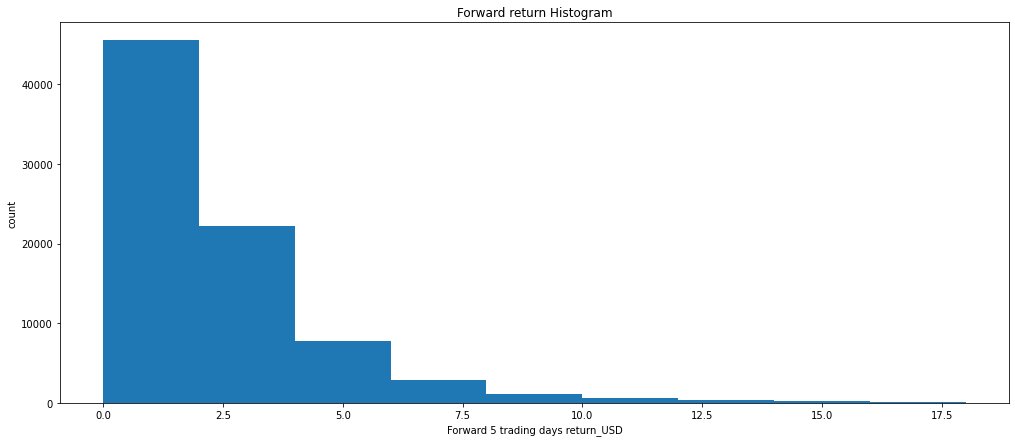

In [37]:
#Forward return Histogram
plt.figure(figsize=(17,7))
plt.hist(data_with_trend_eco_raw['Forward 5 trading days return_USD'], bins=np.arange(0,20, step=2))
plt.xlabel('Forward 5 trading days return_USD')
plt.ylabel('count')
plt.title("Forward return Histogram")

Text(0.5, 1.0, 'positive_return_in_5d Histogram')

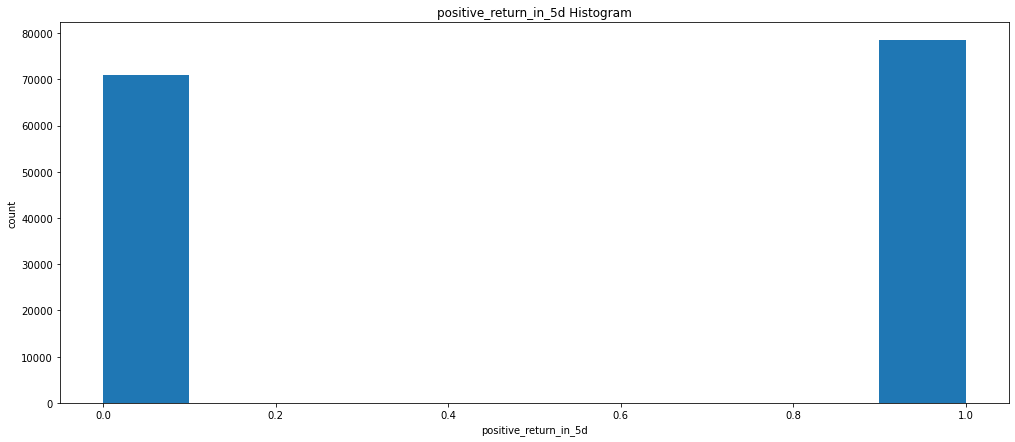

In [38]:
#positive_return_in_5d Histogram
plt.figure(figsize=(17,7))
plt.hist(data_with_trend_eco_final['positive_return_in_5d'])
plt.xlabel('positive_return_in_5d')
plt.ylabel('count')
plt.title("positive_return_in_5d Histogram")

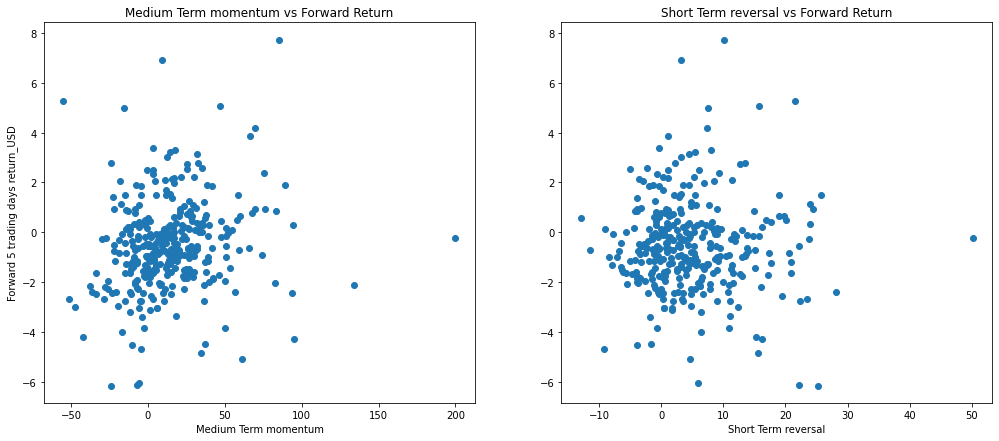

In [39]:
# Medium Term momentum scatterplot 
df_1_Day= data_with_trend_eco_final.loc[data_with_trend_eco_final['Date'] == '2020-12-18']

plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.scatter(df_1_Day[['Medium Term momentum']], df_1_Day[['Forward 5 trading days return_USD']])
plt.xlabel('Medium Term momentum')
plt.ylabel('Forward 5 trading days return_USD')
plt.title("Medium Term momentum vs Forward Return")

# Short Term reversal scatterplot 
plt.subplot(1,2,2)
plt.scatter(df_1_Day[['Short Term reversal']], df_1_Day[['Forward 5 trading days return_USD']])
plt.xlabel('Short Term reversal')
plt.title("Short Term reversal vs Forward Return")
plt.show()


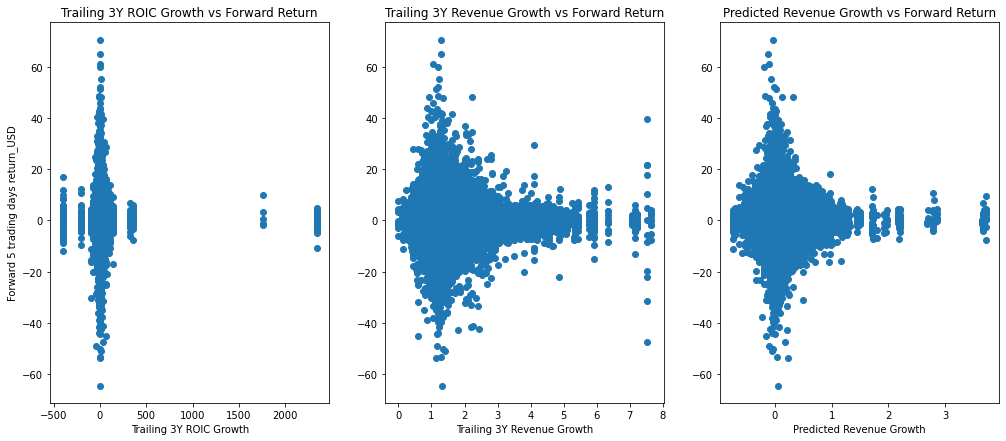

In [40]:
# Trailing 3Y ROIC Growth scatterplot
plt.figure(figsize=(17,7))
plt.subplot(1,3,1)
plt.scatter(data_with_trend_eco_final[['Trailing 3Y ROIC Growth']], data_with_trend_eco_final[['Forward 5 trading days return_USD']])
plt.xlabel('Trailing 3Y ROIC Growth')
plt.ylabel('Forward 5 trading days return_USD')
plt.title("Trailing 3Y ROIC Growth vs Forward Return")

# Trailing 3Y Revenue Growth scatterplot 
plt.subplot(1,3,2)
plt.scatter(data_with_trend_eco_final[['Trailing 3Y Revenue Growth']], data_with_trend_eco_final[['Forward 5 trading days return_USD']])
plt.xlabel('Trailing 3Y Revenue Growth')
plt.title("Trailing 3Y Revenue Growth vs Forward Return")

# Predicted Revenue Growth scatterplot 
plt.subplot(1,3,3)
plt.scatter(data_with_trend_eco_final[['Predicted Revenue Growth']], data_with_trend_eco_final[['Forward 5 trading days return_USD']])
plt.xlabel('Predicted Revenue Growth')
plt.title("Predicted Revenue Growth vs Forward Return")
plt.show()

<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
# 4. Data Preprocessing  

In [41]:
## Drop columns that will not be used for model training
data_with_trend_eco=data_with_trend_eco_final.drop(columns=['Forward 5 trading days return_USD','Date','Symbol','NAME','Trailing 3Y Revenue Growth','Trailing 3Y ROIC Growth','SEDOL'])

## Drop nearly constant feature min_wage
data_with_trend_eco=data_with_trend_eco.drop(columns=['min_wage'])

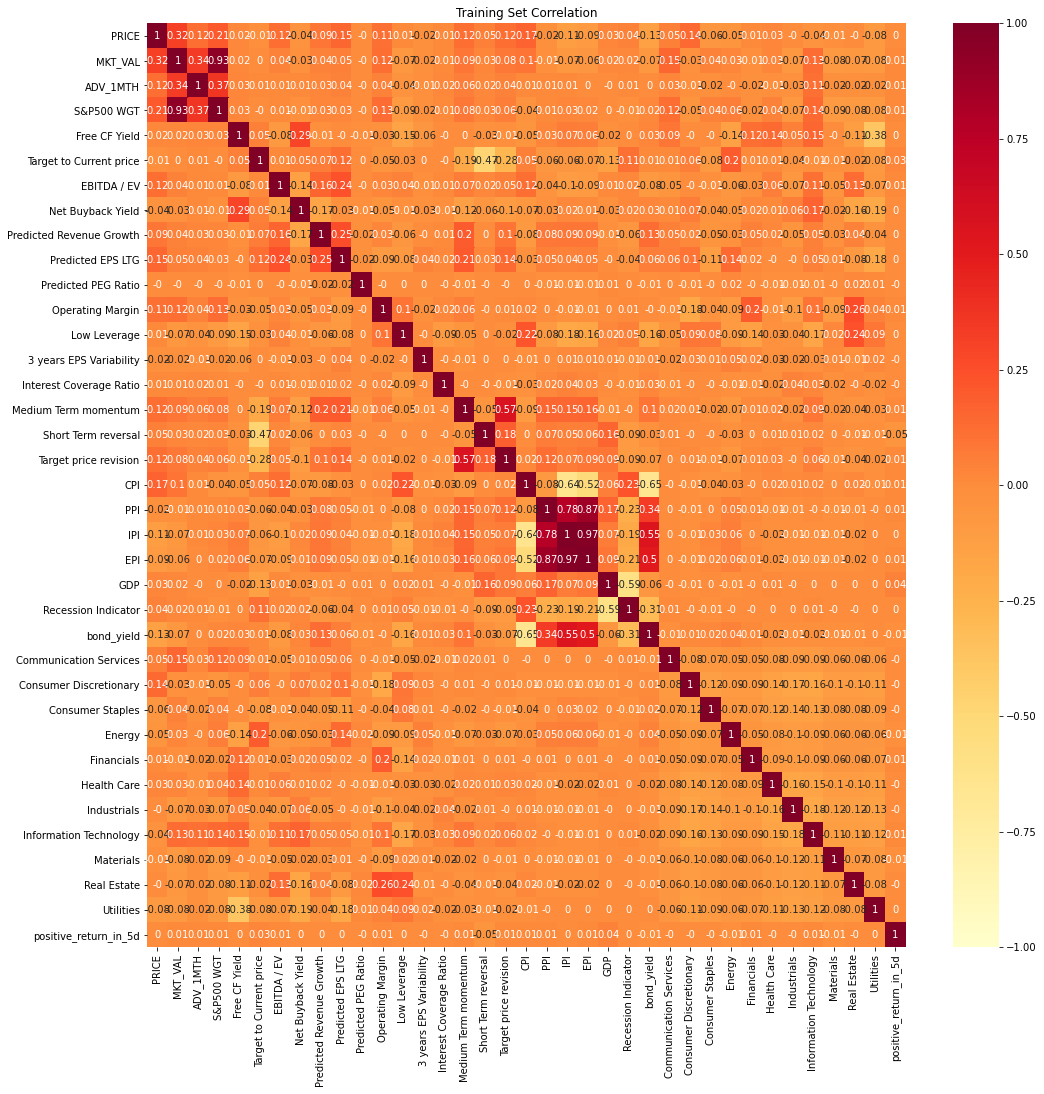

In [42]:
#calculate the correlation
train_corr_matrix = data_with_trend_eco.corr().round(2)
#plot the matrix 
plt.figure(figsize=(17,17))
train_corr_plot = sns.heatmap(train_corr_matrix, cmap="YlOrRd", annot= True, vmin=-1, vmax=1)
train_corr_plot.set_title("Training Set Correlation")
plt.show()

In [43]:
## Drop S&P WGT, PPI, EPI which has strong corr with other features
data_with_trend_eco=data_with_trend_eco.drop(columns=['S&P500 WGT','PPI','EPI'])

In [44]:
data_with_trend_eco.corr()['positive_return_in_5d'].sort_values(ascending=False)

positive_return_in_5d       1.000000
GDP                         0.035595
Target to Current price     0.034708
Information Technology      0.014124
ADV_1MTH                    0.009037
CPI                         0.009028
MKT_VAL                     0.007238
Operating Margin            0.006392
Target price revision       0.006077
Medium Term momentum        0.005904
EBITDA / EV                 0.005258
Financials                  0.005245
PRICE                       0.004769
Utilities                   0.004285
Free CF Yield               0.004164
Predicted EPS LTG           0.004126
Net Buyback Yield           0.003667
Low Leverage                0.003120
Predicted Revenue Growth    0.003095
IPI                         0.002380
Recession Indicator         0.001357
Consumer Discretionary     -0.000237
3 years EPS Variability    -0.000329
Real Estate                -0.000815
Health Care                -0.000818
Interest Coverage Ratio    -0.001021
Industrials                -0.001958
P

In [45]:
# set which variables will be used as the features and which will be the target variable
X = data_with_trend_eco.drop(columns=['positive_return_in_5d'])
y = data_with_trend_eco[['positive_return_in_5d']]

In [46]:
#split the dataset
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=40)

In [47]:
Xtrain.shape

(119517, 33)

In [48]:
Xtest.shape

(29880, 33)

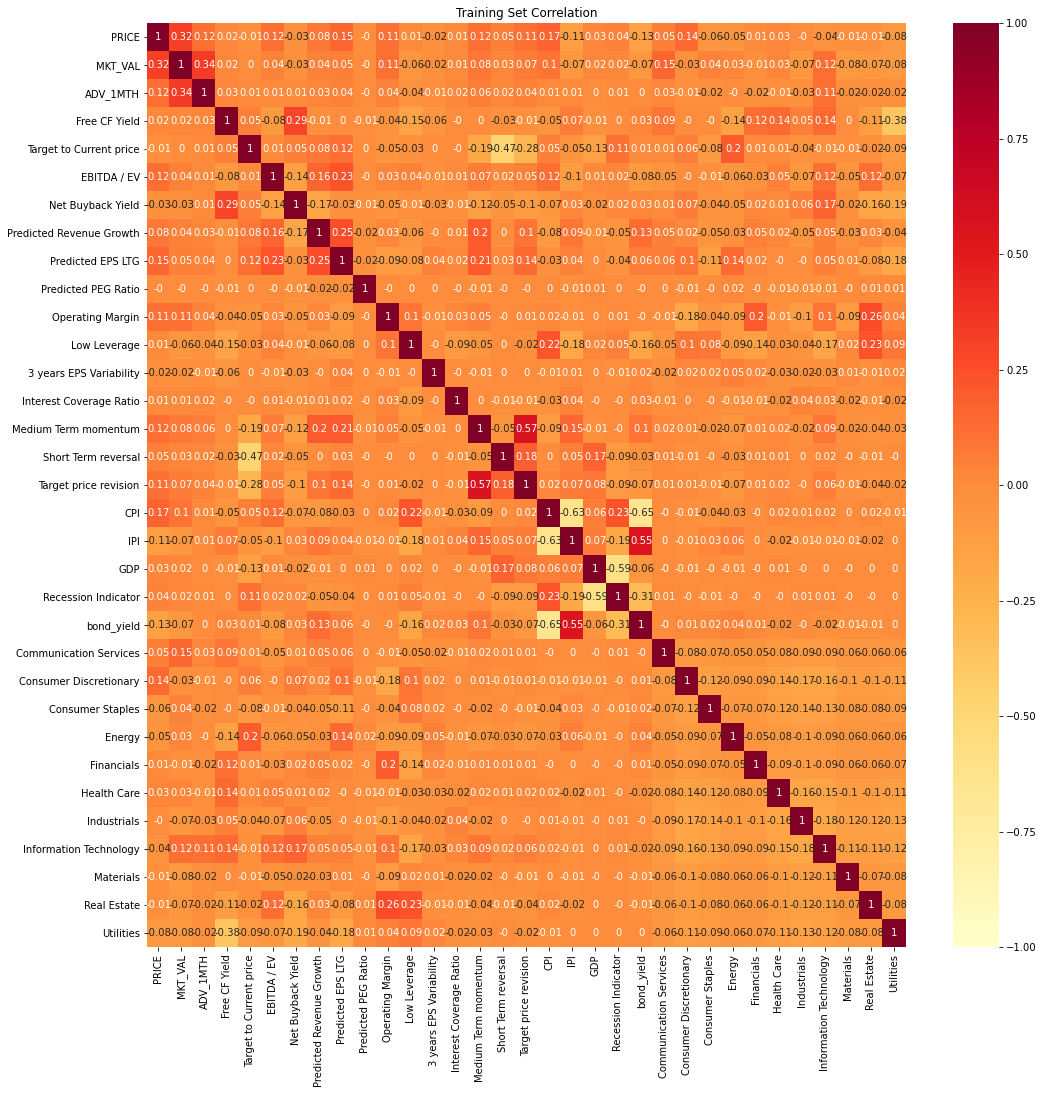

In [49]:
#calculate the correlation based on Xtrain
train_corr_matrix = Xtrain.corr().round(2)
#plot the matrix 
plt.figure(figsize=(17,17))
train_corr_plot = sns.heatmap(train_corr_matrix, cmap="YlOrRd", annot= True, vmin=-1, vmax=1)
train_corr_plot.set_title("Training Set Correlation")
plt.show()

<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
# 5. Modeling

## 5.1 Decison Tree

### 5.1 Decison TreeTraining

In [50]:
#brew install graphviz

In [51]:
#basline decison tree model
import graphviz 
from sklearn import tree
dtree = tree.DecisionTreeClassifier(max_depth=8)
dtree = dtree.fit(Xtrain,ytrain)
dot_data = tree.export_graphviz(dtree, 
                filled=True, 
                feature_names=list(Xtrain),
                class_names=['No positive return','Positive return'],
                special_characters=True)
graph = graphviz.Source(dot_data)  

In [52]:
#graph

In [53]:
## Investigate the feature importance
dtree.feature_importances_

array([0.01040915, 0.00970605, 0.02038306, 0.01280647, 0.04263084,
       0.01435222, 0.00904833, 0.02210195, 0.00862139, 0.01712655,
       0.00440586, 0.00789643, 0.01224398, 0.00561919, 0.02384912,
       0.19723316, 0.05851184, 0.15893085, 0.11156884, 0.08419271,
       0.0544097 , 0.07370493, 0.        , 0.00362076, 0.00307275,
       0.01839692, 0.        , 0.        , 0.00410532, 0.        ,
       0.        , 0.        , 0.01105164])

In [54]:
importances = pd.DataFrame({'feature':Xtrain.columns,'importance':np.round(dtree.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
15,Short Term reversal,0.197
17,CPI,0.159
18,IPI,0.112
19,GDP,0.084
21,bond_yield,0.074
16,Target price revision,0.059
20,Recession Indicator,0.054
4,Target to Current price,0.043
14,Medium Term momentum,0.024
7,Predicted Revenue Growth,0.022


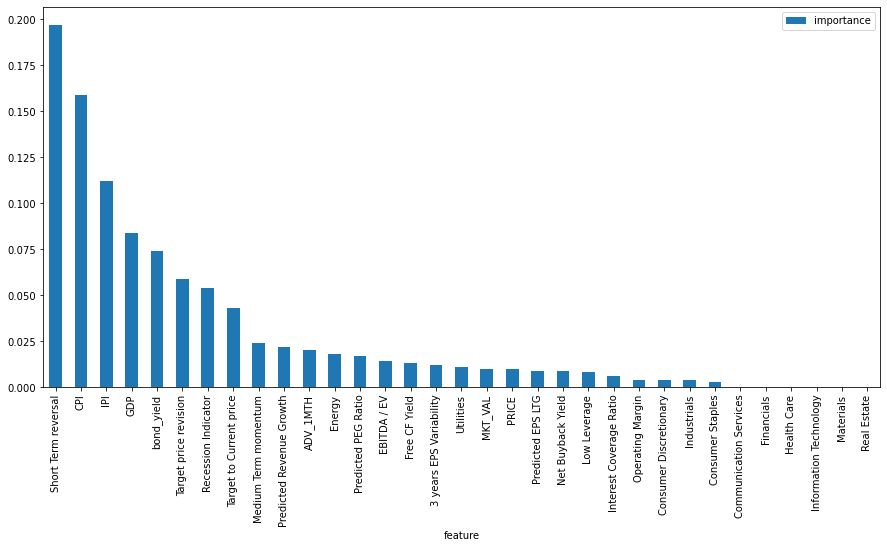

In [55]:
# Visualize feature importance
ax = importances.plot.bar(x='feature', y='importance' ,figsize=(15,7))

## 5.2 D-Tree Cross validation & Hyperparameter Tuning

In [56]:
## Feed the trained model with test sample
# y predicted
ypred_dtree = dtree.predict(Xtest)
ypred_dtree

array([1, 0, 1, ..., 0, 1, 0])

In [57]:
from sklearn.metrics import accuracy_score
acc_log = dtree.score(Xtrain, ytrain)
print('training accuracy: %.5f' % acc_log)
x=accuracy_score(ytest, ypred_dtree)
print('test accuracy: %.5f' % x)

training accuracy: 0.56156
test accuracy: 0.55248


### 5.2.1 Accuracy

In [58]:
## Tuning max_depth
tree_train_acc=[]   #acc for training
tree_test_acc=[]    #acc for testing
tree_depth=[]       #try different max_depth

for i in range (2,20):
    dtree=tree.DecisionTreeClassifier(max_depth=i)
    dtree=dtree.fit(Xtrain,ytrain)
    acc_log = dtree.score(Xtrain, ytrain)
    print('max_depth=%d ' % i,'training accuracy: %.5f' % acc_log)
    
    predict_y = dtree.predict(Xtest)    
    X=accuracy_score(ytest, predict_y)
    print('\t\ttest accuracy: %.5f' % X)
    
    tree_train_acc.append(acc_log)
    tree_test_acc.append(X)
    tree_depth.append(i)

max_depth=2  training accuracy: 0.53025
		test accuracy: 0.52597
max_depth=3  training accuracy: 0.53697
		test accuracy: 0.53307
max_depth=4  training accuracy: 0.54207
		test accuracy: 0.53886
max_depth=5  training accuracy: 0.55011
		test accuracy: 0.54705
max_depth=6  training accuracy: 0.55343
		test accuracy: 0.54776
max_depth=7  training accuracy: 0.55672
		test accuracy: 0.54859
max_depth=8  training accuracy: 0.56156
		test accuracy: 0.55224
max_depth=9  training accuracy: 0.56727
		test accuracy: 0.54843
max_depth=10  training accuracy: 0.57743
		test accuracy: 0.54448
max_depth=11  training accuracy: 0.58805
		test accuracy: 0.54823
max_depth=12  training accuracy: 0.59928
		test accuracy: 0.54491
max_depth=13  training accuracy: 0.61440
		test accuracy: 0.54552
max_depth=14  training accuracy: 0.63066
		test accuracy: 0.54391
max_depth=15  training accuracy: 0.64758
		test accuracy: 0.53989
max_depth=16  training accuracy: 0.66867
		test accuracy: 0.53440
max_depth=17  trai

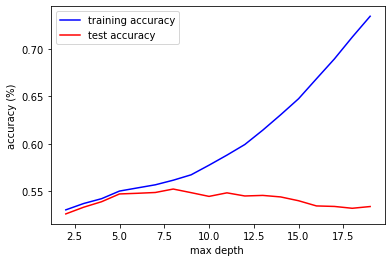

In [59]:
plt.plot(tree_depth,tree_train_acc,'b', label="training accuracy")
plt.plot(tree_depth,tree_test_acc,'r', label="test accuracy")
plt.ylabel('accuracy (%)')
plt.xlabel('max depth ')
plt.legend()
plt.show()

In [60]:
best_depth = tree_depth[tree_test_acc.index(max(tree_test_acc))]
print ("max depth: ", best_depth)
print ("with best test accuracy: %.5f"% max(tree_test_acc))

max depth:  8
with best test accuracy: 0.55224


### 5.2.2 Precision

In [62]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
## Tuning max_depth by looking at precision
tree_train_prec=[]   #precision for training   
tree_test_prec=[]    #precision for testing
tree_depth=[]       #try different max_depth

for i in range (2,20):
    dtree=tree.DecisionTreeClassifier(max_depth=i)
    dtree=dtree.fit(Xtrain,ytrain)
    y_pred_train=dtree.predict(Xtrain)
    train_prec_log = precision_score(ytrain, y_pred_train, average='macro')
    print('max_depth=%d ' % i,'training precision: %.5f' % train_prec_log)
    
    y_pred_test = dtree.predict(Xtest)    
    test_prec_log = precision_score(ytest, y_pred_test, average='macro')
    print('\t\ttest precision: %.5f' % test_prec_log)
    
    tree_train_prec.append(train_prec_log)
    tree_test_prec.append(test_prec_log)
    tree_depth.append(i)

max_depth=2  training precision: 0.60929
		test precision: 0.61903
max_depth=3  training precision: 0.53465
		test precision: 0.53302
max_depth=4  training precision: 0.54022
		test precision: 0.53924
max_depth=5  training precision: 0.55601
		test precision: 0.55555
max_depth=6  training precision: 0.55211
		test precision: 0.54739
max_depth=7  training precision: 0.55728
		test precision: 0.54967
max_depth=8  training precision: 0.56436
		test precision: 0.55524
max_depth=9  training precision: 0.57007
		test precision: 0.54858
max_depth=10  training precision: 0.57523
		test precision: 0.54176
max_depth=11  training precision: 0.58688
		test precision: 0.54514
max_depth=12  training precision: 0.59781
		test precision: 0.54255
max_depth=13  training precision: 0.61420
		test precision: 0.54250
max_depth=14  training precision: 0.63069
		test precision: 0.54153
max_depth=15  training precision: 0.64704
		test precision: 0.53753
max_depth=16  training precision: 0.66843
		test precisi

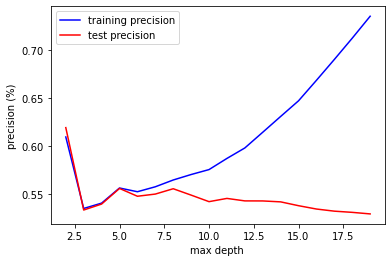

In [63]:
plt.plot(tree_depth,tree_train_prec,'b', label="training precision")
plt.plot(tree_depth,tree_test_prec,'r', label="test precision")
plt.ylabel('precision (%)')
plt.xlabel('max depth ')
plt.legend()
plt.show()

In [64]:
## Overall, max_depth should be 8 for decision trees
# Train the best decision tree model
dtree=tree.DecisionTreeClassifier(max_depth=8)
dtree=dtree.fit(Xtrain,ytrain)
predict_y = dtree.predict(Xtest)

## Other metrics of the best model
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
fpr, tpr, thresholds = metrics.roc_curve(ytest, predict_y, pos_label=1)
print('auc: %.5f' % metrics.auc(fpr, tpr))
print('F1_score: %.5f' % f1_score(ytest, predict_y, average="macro"))
print('Precision_score: %.5f' % precision_score(ytest, predict_y, average="macro"))
print('Recall_rate: %.5f' % recall_score(ytest, predict_y, average="macro")) 

auc: 0.54224
F1_score: 0.51915
Precision_score: 0.55502
Recall_rate: 0.54224


### 5.2.3 Customized metric focusing on the Top-5 predictions

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import make_scorer

def score_func(y_actual,y_pred):
    return np.mean(y_actual[y_pred.argsort()[-5:]])

my_scorer = make_scorer(score_func, greater_is_better=True,needs_proba=True)

In [66]:
##convert ytrain to array
ytrain_dt=np.array(ytrain)

In [67]:
## Tuning max_depth by looking at my_scorer
scores = []
for depth in range(2,12):
    dtree=tree.DecisionTreeClassifier(max_depth=depth)
    score=cross_val_score(dtree,Xtrain,ytrain_dt,cv=5,scoring=my_scorer)
    scores.append(score.mean())
    print(depth)

2
3
4
5
6
7
8
9
10
11


In [68]:
scores

[0.6,
 0.6399999999999999,
 0.5599999999999999,
 0.5200000000000001,
 0.52,
 0.36,
 0.48,
 0.36,
 0.48,
 0.44000000000000006]

#### max_depth can be 9 based on my_scorer, but the score is still not satisfied. 

## 5.2 Random Forest

In [69]:
##Flatten ytrain for random forest
ytrain_rf=np.array(ytrain).flatten()

In [70]:
## Cross validation based on my_scorer
from sklearn.ensemble import RandomForestClassifier
scores = []
for depth in range(2,12):
    rf=RandomForestClassifier(max_depth=depth)
    score=cross_val_score(rf,Xtrain,ytrain_rf,cv=5,scoring=my_scorer)
    scores.append(score.mean())
    print(depth)

2
3
4
5
6
7
8
9
10
11


In [71]:
scores

[0.72,
 0.8400000000000001,
 0.8400000000000001,
 0.8400000000000001,
 0.9199999999999999,
 0.96,
 0.8800000000000001,
 0.9199999999999999,
 1.0,
 0.8800000000000001]

In [72]:
##Best rf model:
rf=RandomForestClassifier(max_depth=10)
rf=rf.fit(Xtrain,ytrain_rf)

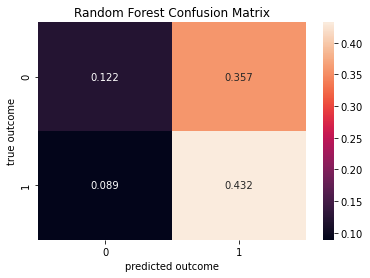

In [73]:
from sklearn.metrics import confusion_matrix
ypred_rf = rf.predict(Xtest)
rf_cm = confusion_matrix(ytest, ypred_rf)

sns.heatmap(rf_cm/np.sum(rf_cm), annot=True, fmt='.3f')
plt.xlabel('predicted outcome')
plt.ylabel('true outcome')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [74]:
confusion_matrix(ytest, ypred_rf)

array([[ 3635, 10676],
       [ 2654, 12915]])

In [75]:
## Metrics of the best Random Forest model
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred_rf, pos_label=1)
print('auc: %.5f' % metrics.auc(fpr, tpr))
print('F1_score: %.5f' % f1_score(ytest, ypred_rf, average="macro"))
print('Precision_score: %.5f' % precision_score(ytest, ypred_rf, average="macro"))
print('Recall_rate: %.5f' % recall_score(ytest, ypred_rf, average="macro")) 

auc: 0.54177
F1_score: 0.50626
Precision_score: 0.56272
Recall_rate: 0.54177


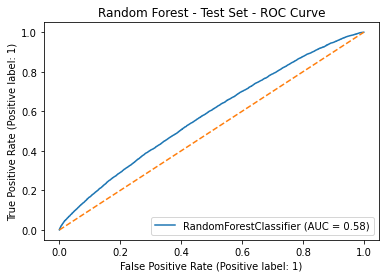

In [80]:
metrics.plot_roc_curve(rf, Xtest, ytest )
plt.plot([0,1],[0,1], '--')
plt.title('Random Forest - Test Set - ROC Curve')
plt.show()

In [76]:
rf_importances = pd.DataFrame({'feature':Xtrain.columns,'importance':np.round(rf.feature_importances_,3)})
rf_importances = importances.sort_values('importance',ascending=False)
rf_importances

,feature,importance
15,Short Term reversal,0.197
17,CPI,0.159
18,IPI,0.112
19,GDP,0.084
21,bond_yield,0.074
16,Target price revision,0.059
20,Recession Indicator,0.054
4,Target to Current price,0.043
14,Medium Term momentum,0.024
7,Predicted Revenue Growth,0.022


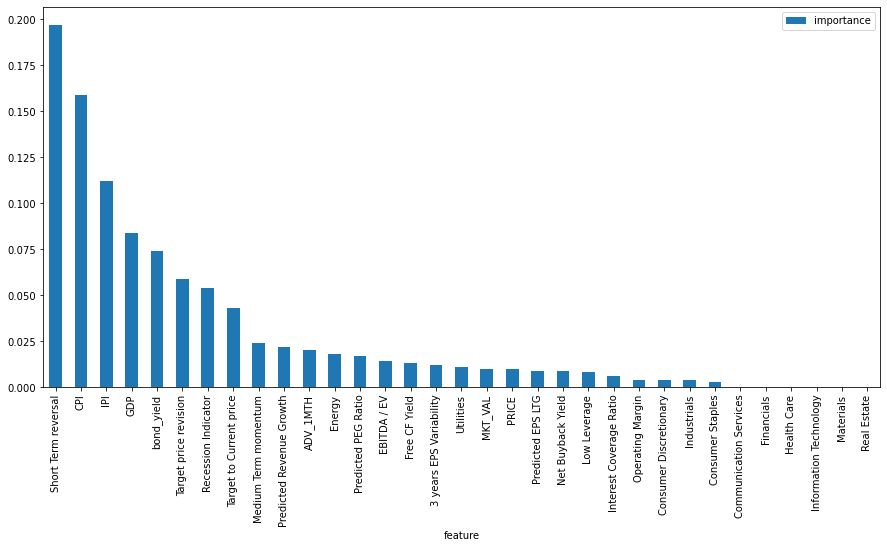

In [77]:
# Visualize feature importance
ax = rf_importances.plot.bar(x='feature', y='importance' ,figsize=(15,7))

<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
# 6. Forecasting

In [102]:
## Read new-day data on 20210816 (price and fundamental data)
df = pd.read_csv('20210816.csv', sep = ',')

In [103]:
## Read new-day data on 20210816 (macro-economic data)
df_full=pd.merge(df,
                 data_with_trend_eco_final[['Symbol', 'Communication Services','Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials',
                    'Health Care', 'Industrials', 'Information Technology', 'Materials','Real Estate', 'Utilities']],
                 on='Symbol', 
                 how='left')

In [104]:
df_full=df_full.drop_duplicates() 
df_full.reset_index(drop=True, inplace=True)
#Drop records with null values
df_full=df_full.dropna()
##Drop irevelant columns
Xnew=df_full.drop(['Symbol','NAME'], axis=1)

In [105]:
Xnew.head()

,PRICE,MKT_VAL,ADV_1MTH,Free CF Yield,Target to Current price,EBITDA / EV,Net Buyback Yield,Predicted Revenue Growth,Predicted EPS LTG,Predicted PEG Ratio,...,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,151.1,2498038.6,1.130540e+10,0.0,0.1,26.1,0.0,0.3,18.6,1.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,294.6,2213887.0,6.296561e+09,0.0,0.1,24.8,0.0,0.1,11.8,2.9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3299.0,1670742.2,1.118731e+10,0.0,0.3,41.4,0.0,0.2,31.3,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2766.2,1848254.4,3.751910e+09,0.0,0.1,19.8,0.0,0.4,17.0,1.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,686.2,679318.7,1.332644e+10,0.0,0.0,175.6,0.0,0.6,40.9,3.4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
## Ajust column types
Xnew = Xnew.astype({"PRICE": np.float64, "MKT_VAL": np.float64,"ADV_1MTH": np.float64,"Predicted PEG Ratio": np.float64,"3 years EPS Variability": np.float64})

In [107]:
Xnew.shape

(339, 33)

In [108]:
# predict probabilities (the class probability from the number of samples of each class that fall into a given leaf)
yprednew_prob_rf=rf.predict_proba(Xnew)[:,1]
yprednew_prob_rf

array([0.55724245, 0.51877724, 0.58188112, 0.5124281 , 0.50558814,
       0.50654312, 0.4984488 , 0.64721304, 0.53334675, 0.5318551 ,
       0.59999038, 0.59145221, 0.62134017, 0.51064879, 0.50073926,
       0.54701887, 0.54807467, 0.52859662, 0.54694388, 0.57710516,
       0.58625962, 0.57090865, 0.50229439, 0.54268185, 0.54035562,
       0.49998589, 0.62398677, 0.46632112, 0.55209271, 0.50254777,
       0.51908396, 0.48568463, 0.54300749, 0.49343033, 0.53162248,
       0.58311591, 0.5349714 , 0.54932435, 0.56264521, 0.54163786,
       0.54698495, 0.50657973, 0.52491555, 0.54886741, 0.55938157,
       0.54843919, 0.53819991, 0.45862999, 0.60068442, 0.58618265,
       0.60577466, 0.59400218, 0.54851249, 0.53241408, 0.56615367,
       0.5424038 , 0.56513653, 0.52499432, 0.5219247 , 0.55276161,
       0.55493819, 0.53514169, 0.5338064 , 0.53940174, 0.58519532,
       0.5146115 , 0.52520391, 0.51175189, 0.57073074, 0.51288774,
       0.56142303, 0.57365797, 0.58855588, 0.59536707, 0.53358

In [109]:
def n_largest(arr, n):
    # np.argsort() return array of indices for sorted array
    sorted_index_array = np.argsort(arr)

    # sorted array
    sorted_array = arr[sorted_index_array]
    # find n largest value
    n_largest_rslt = sorted_array[-n : ]
    # show the output
    return n_largest_rslt

In [110]:
n_largest(yprednew_prob_rf,5)

array([0.63287388, 0.63713287, 0.63785696, 0.64021259, 0.64721304])

In [111]:
prob_threshold=n_largest(yprednew_prob_rf,5)[-5]

In [112]:
## Extract the index of stock which has the highest price growth chance
result = numpy.where(yprednew_prob_rf >= prob_threshold)  
print(len(result[0]))
print('Returned tuple of arrays :', result)

5
Returned tuple of arrays : (array([  7, 301, 304, 311, 321]),)


In [113]:
## Recommending the 5 stocks
df_full.iloc[[7, 301, 304, 311, 321]]

,Symbol,NAME,PRICE,MKT_VAL,ADV_1MTH,Free CF Yield,Target to Current price,EBITDA / EV,Net Buyback Yield,Predicted Revenue Growth,...,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
10,V,Visa Inc. Class A,235.4,500567.6,1.821936e+09,0.0,0.2,30.4,0.0,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
424,LDOS,"Leidos Holdings, Inc.",97.9,13857.8,7.887273e+07,0.0,0.2,14.6,0.0,0.1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
429,CTXS,"Citrix Systems, Inc.",102.2,12692.8,2.183953e+08,0.0,0.1,20.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
442,FMC,FMC Corporation,92.8,11943.3,8.928192e+07,0.0,0.3,13.9,0.0,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
464,LW,"Lamb Weston Holdings, Inc.",66.5,9643.2,9.854112e+07,0.0,0.3,21.4,0.0,0.1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Recommending the 5 stocks: V, LDOS, CTXS, FMC, LW

<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>
# Findings on the 5 stocks

In [123]:
## Data visualization

import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

In [115]:
start=datetime.datetime(2015,1,1)
end=datetime.datetime(2021,8,16)

In [117]:
visa=web.DataReader("V",'yahoo',start,end)
leidos=web.DataReader("LDOS",'yahoo',start,end)
citrix=web.DataReader("CTXS",'yahoo',start,end)
fmc=web.DataReader("FMC",'yahoo',start,end)
lamb_weston=web.DataReader("LW",'yahoo',start,end)

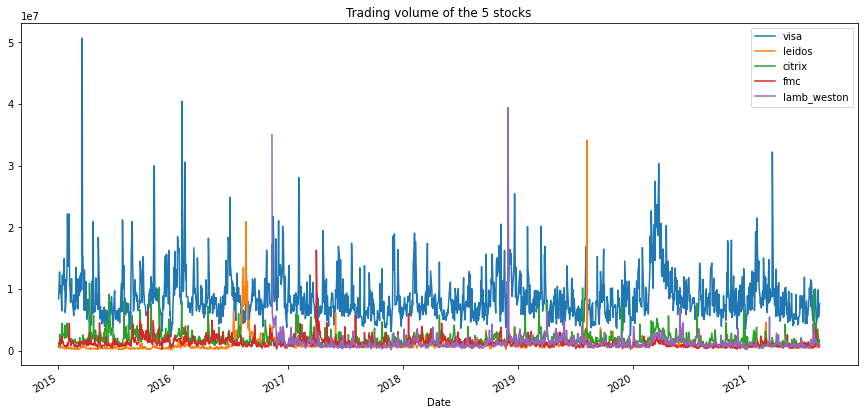

In [118]:
visa['Volume'].plot(label='visa',figsize=(15,7))
leidos['Volume'].plot(label='leidos',figsize=(15,7))
citrix['Volume'].plot(label='citrix',figsize=(15,7))
fmc['Volume'].plot(label='fmc',figsize=(15,7))
lamb_weston['Volume'].plot(label='lamb_weston',figsize=(15,7))
plt.title('Trading volume of the 5 stocks')
plt.legend()

In [119]:
from pandas.plotting import scatter_matrix
import pandas as pd

comp= pd.concat([visa['Close'],leidos['Close'],citrix['Close'],fmc['Close'],lamb_weston['Close']],axis = 1)
comp.columns=['visa_close','leidos_close','citrix_close','fmc_close','lamb_weston_close']

array([[<AxesSubplot:xlabel='visa_close', ylabel='visa_close'>,
        <AxesSubplot:xlabel='leidos_close', ylabel='visa_close'>,
        <AxesSubplot:xlabel='citrix_close', ylabel='visa_close'>,
        <AxesSubplot:xlabel='fmc_close', ylabel='visa_close'>,
        <AxesSubplot:xlabel='lamb_weston_close', ylabel='visa_close'>],
       [<AxesSubplot:xlabel='visa_close', ylabel='leidos_close'>,
        <AxesSubplot:xlabel='leidos_close', ylabel='leidos_close'>,
        <AxesSubplot:xlabel='citrix_close', ylabel='leidos_close'>,
        <AxesSubplot:xlabel='fmc_close', ylabel='leidos_close'>,
        <AxesSubplot:xlabel='lamb_weston_close', ylabel='leidos_close'>],
       [<AxesSubplot:xlabel='visa_close', ylabel='citrix_close'>,
        <AxesSubplot:xlabel='leidos_close', ylabel='citrix_close'>,
        <AxesSubplot:xlabel='citrix_close', ylabel='citrix_close'>,
        <AxesSubplot:xlabel='fmc_close', ylabel='citrix_close'>,
        <AxesSubplot:xlabel='lamb_weston_close', ylabel='citr

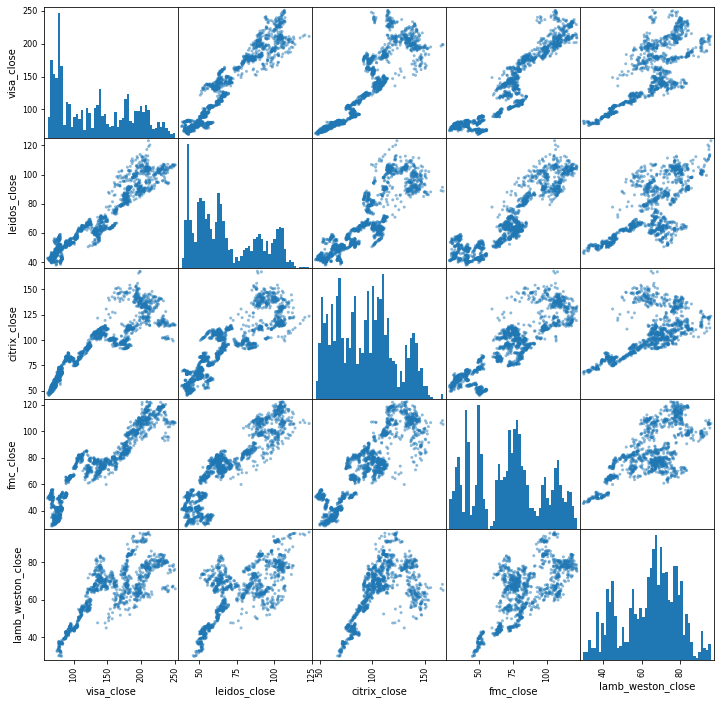

In [121]:
scatter_matrix(comp, figsize=(12,12),hist_kwds={'bins': 50})

#### There seems to be some correlation between visa and leidos.